In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.ndimage import map_coordinates, gaussian_filter
import time
import warnings


In [13]:
# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [14]:
# Constants
DELTA_T = 0.1
NUM_STEPS = 10
SIGMA_DEFAULT = 1.0


In [15]:
def load_data():
    """
    Load the initial velocity field and source image.

    Returns:
        tuple: A tuple containing:
            - velocity (ndarray): Initial velocity field of shape (2, 100, 100).
            - source_image (ndarray): Source image of shape (100, 100).
    """
    velocity = torch.load('v0.pt').numpy()  # Initial velocity field (2, 100, 100)
    print("Dimension of velocity V0:", velocity.shape)
    source = torch.load('source.pt').numpy()  # Source image (100, 100)
    print("Dimension of image:", source.shape)
    source_image = source
    return velocity, source_image

In [16]:
def display_image(image, title='Image', cmap='gray'):
    """
    Display a single image.

    Args:
        image (ndarray): Image to display.
        title (str): Title of the image.
        cmap (str): Colormap to use for displaying the image.
    """
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()


In [17]:
def central_difference_x(u):
    """Compute the central difference approximation of the derivative in the x-direction."""
    return (np.roll(u, -1, axis=1) - np.roll(u, 1, axis=1)) / 2.0


In [18]:
def central_difference_y(u):
    """Compute the central difference approximation of the derivative in the y-direction."""
    return (np.roll(u, -1, axis=0) - np.roll(u, 1, axis=0)) / 2.0


In [19]:
def compute_divergence(vx, vy):
    """
    Compute the divergence of a vector field.

    Args:
        vx (ndarray): x-component of the vector field.
        vy (ndarray): y-component of the vector field.

    Returns:
        ndarray: The divergence of the vector field.
    """
    dvx_dx = central_difference_x(vx)
    dvy_dy = central_difference_y(vy)
    return dvx_dx + dvy_dy


In [20]:
def geodesic_shooting_inverse(v_t_initial, source_image, X, Y, delta_t=DELTA_T, num_steps=NUM_STEPS, sigma=SIGMA_DEFAULT):
    """
    Perform inverse geodesic shooting with the given initial velocity field.

    Args:
        v_t_initial (ndarray): Initial velocity field of shape (2, img_rows, img_cols).
        source_image (ndarray): Source image of shape (img_rows, img_cols).
        X (ndarray): Meshgrid X coordinates.
        Y (ndarray): Meshgrid Y coordinates.
        delta_t (float): Time step size.
        num_steps (int): Number of time steps to perform.
        sigma (float): Standard deviation for Gaussian smoothing.

    Returns:
        tuple: A tuple containing:
            - v_t (ndarray): Final velocity field after inverse geodesic shooting.
            - phi_inv_t (ndarray): Final inverse deformation field.
            - deformed_images (list): List of deformed images at each time step.
            - total_time (float): Total computation time in seconds.
    """
    v_t = v_t_initial.copy()
    phi_inv_t = np.array([X, Y])  # Initialize the inverse deformation field
    deformed_images = []
    start_time = time.time()
    
    for step in range(num_steps):
        # Extract velocity components
        v_x = v_t[0]
        v_y = v_t[1]
        
        # Compute spatial derivatives
        dvx_dx = central_difference_x(v_x)
        dvx_dy = central_difference_y(v_x)
        dvy_dx = central_difference_x(v_y)
        dvy_dy = central_difference_y(v_y)
        
        # Compute divergence
        div_v_t = dvx_dx + dvy_dy
        
        # Compute terms for dv_t/dt
        term1_x = dvx_dx * v_x + dvy_dx * v_y
        term1_y = dvx_dy * v_x + dvy_dy * v_y
        
        term2_x = dvx_dx * v_x + dvx_dy * v_y
        term2_y = dvy_dx * v_x + dvy_dy * v_y
        
        term3_x = v_x * div_v_t
        term3_y = v_y * div_v_t
        
        # Sum terms
        dv_t_terms_x = term1_x + term2_x + term3_x
        dv_t_terms_y = term1_y + term2_y + term3_y
        
        # Apply Gaussian smoothing
        dv_t_terms_x_smoothed = gaussian_filter(dv_t_terms_x, sigma=sigma)
        dv_t_terms_y_smoothed = gaussian_filter(dv_t_terms_y, sigma=sigma)
        
        # Compute dv_t/dt
        dv_t_dt_x = dv_t_terms_x_smoothed
        dv_t_dt_y = dv_t_terms_y_smoothed
        
        # Update velocity field
        v_t[0] = v_x + delta_t * dv_t_dt_x
        v_t[1] = v_y + delta_t * dv_t_dt_y
        
        # Compute gradients of phi_inv_t
        dphi_inv_dx_x = central_difference_x(phi_inv_t[0])
        dphi_inv_dy_x = central_difference_y(phi_inv_t[0])
        dphi_inv_dx_y = central_difference_x(phi_inv_t[1])
        dphi_inv_dy_y = central_difference_y(phi_inv_t[1])
        
        # Jacobian D phi_inv_t
        D_phi_inv = np.array([
            [dphi_inv_dx_x, dphi_inv_dy_x],
            [dphi_inv_dx_y, dphi_inv_dy_y]
        ])  # Shape: (2, 2, img_rows, img_cols)
        
        # Reshape for matrix multiplication
        D_phi_inv = D_phi_inv.reshape(2, 2, -1)
        v_t_flat = v_t.reshape(2, -1)
        
        # Compute -D phi_inv_t ⋅ v_t
        dv_inv_dt = -np.einsum('abj,bj->aj', D_phi_inv, v_t_flat)
        dv_inv_dt = dv_inv_dt.reshape(2, phi_inv_t.shape[1], phi_inv_t.shape[2])
        
        # Update phi_inv_t
        phi_inv_t = phi_inv_t + delta_t * dv_inv_dt
        
        # Deform the source image
        deformed_coords = [phi_inv_t[1], phi_inv_t[0]]  # Coordinates for interpolation
        s_deformed = map_coordinates(source_image, deformed_coords, order=3, mode='nearest')
        deformed_images.append(s_deformed)
    
    end_time = time.time()
    total_time = end_time - start_time
    return v_t, phi_inv_t, deformed_images, total_time


In [21]:
def geodesic_shooting(v_t_initial, source_image, X, Y, delta_t=DELTA_T, num_steps=NUM_STEPS, sigma=SIGMA_DEFAULT):
    """
    Perform geodesic shooting with the given initial velocity field.

    Args:
        v_t_initial (ndarray): Initial velocity field of shape (2, img_rows, img_cols).
        source_image (ndarray): Source image of shape (img_rows, img_cols).
        X (ndarray): Meshgrid X coordinates.
        Y (ndarray): Meshgrid Y coordinates.
        delta_t (float): Time step size.
        num_steps (int): Number of time steps to perform.
        sigma (float): Standard deviation for Gaussian smoothing.

    Returns:
        tuple: A tuple containing:
            - v_t (ndarray): Final velocity field after geodesic shooting.
            - phi_t (ndarray): Final deformation field.
            - deformed_images (list): List of deformed images at each time step.
            - total_time (float): Total computation time in seconds.
    """
    v_t = v_t_initial.copy()
    phi_t = np.array([X, Y])  # Initialize the deformation field
    deformed_images = []
    start_time = time.time()
    
    for step in range(num_steps):
        # Extract velocity components
        v_x = v_t[0]
        v_y = v_t[1]
        
        # Compute spatial derivatives
        dvx_dx = central_difference_x(v_x)
        dvx_dy = central_difference_y(v_x)
        dvy_dx = central_difference_x(v_y)
        dvy_dy = central_difference_y(v_y)
        
        # Compute divergence
        div_v_t = dvx_dx + dvy_dy
        
        # Compute terms for dv_t/dt
        term1_x = dvx_dx * v_x + dvy_dx * v_y
        term1_y = dvx_dy * v_x + dvy_dy * v_y
        
        term2_x = dvx_dx * v_x + dvx_dy * v_y
        term2_y = dvy_dx * v_x + dvy_dy * v_y
        
        term3_x = v_x * div_v_t
        term3_y = v_y * div_v_t
        
        # Sum terms
        dv_t_terms_x = term1_x + term2_x + term3_x
        dv_t_terms_y = term1_y + term2_y + term3_y
        
        # Apply Gaussian smoothing
        dv_t_terms_x_smoothed = gaussian_filter(dv_t_terms_x, sigma=sigma)
        dv_t_terms_y_smoothed = gaussian_filter(dv_t_terms_y, sigma=sigma)
        
        # Compute dv_t/dt
        dv_t_dt_x = -dv_t_terms_x_smoothed
        dv_t_dt_y = -dv_t_terms_y_smoothed
        
        # Update velocity field
        v_t[0] = v_x + delta_t * dv_t_dt_x
        v_t[1] = v_y + delta_t * dv_t_dt_y
        
        # Interpolate velocity at phi_t to compute dphi_t/dt
        coords = [phi_t[1], phi_t[0]]  # Coordinates are (rows, cols)
        v_x_at_phi = map_coordinates(v_t[0], coords, order=3, mode='nearest')
        v_y_at_phi = map_coordinates(v_t[1], coords, order=3, mode='nearest')
        
        # Update deformation field
        phi_t[0] = phi_t[0] + delta_t * v_x_at_phi
        phi_t[1] = phi_t[1] + delta_t * v_y_at_phi
        
        # Deform the source image
        deformed_coords = [phi_t[1], phi_t[0]]  # Coordinates for interpolation
        s_deformed = map_coordinates(source_image, deformed_coords, order=3, mode='nearest')
        deformed_images.append(s_deformed)
    
    end_time = time.time()
    total_time = end_time - start_time
    return v_t, phi_t, deformed_images, total_time


Dimension of velocity V0: (2, 100, 100)
Dimension of image: (100, 100)


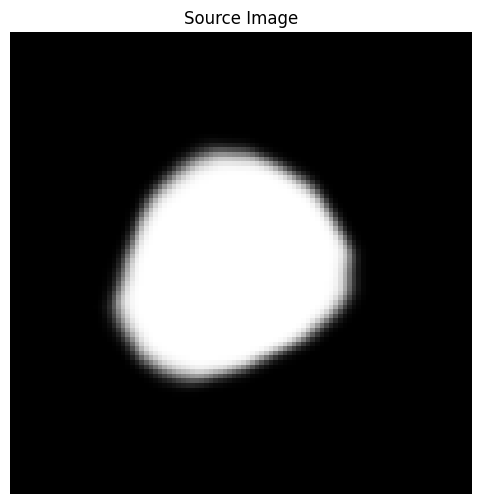

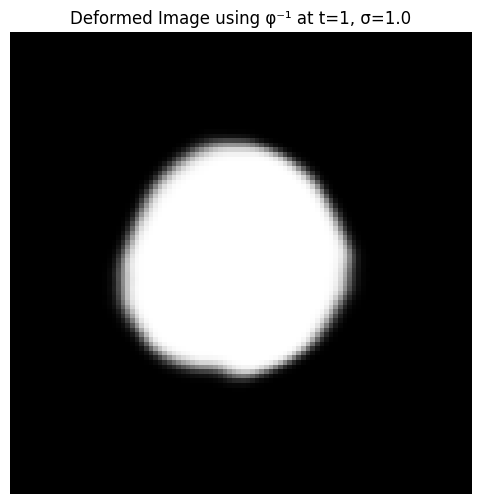

In [22]:
def main():
    """
    Main function to run geodesic shooting and inverse geodesic shooting, and display results.
    """
    # Load data
    velocity, source_image = load_data()
    
    # Display the source image
    display_image(source_image, title='Source Image')
    
    # Initialize variables
    img_rows, img_cols = source_image.shape
    x = np.arange(img_cols)
    y = np.arange(img_rows)
    X, Y = np.meshgrid(x, y)
    
    # Set initial velocity and sigma
    v0 = velocity
    sigma = SIGMA_DEFAULT
    
    # Run inverse geodesic shooting
    v_t_final_inv, phi_inv_t_final, deformed_images_inv, total_time_inv = geodesic_shooting_inverse(
        v0, source_image, X, Y, sigma=sigma
    )
    
    # Display the final deformed image using phi_inv_t at t=1
    final_deformed_image_inv = deformed_images_inv[-1]
    display_image(final_deformed_image_inv, title=f'Deformed Image using φ⁻¹ at t=1, σ={sigma}')

if __name__ == "__main__":
    main()
